# BIOSTAT707 Group Project

RNN/LSTM Model

Developed by: Jackson Dial and Caitlyn Nguyen

The following code is adapted from:
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [183]:
# Library import
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Set Seed
tf.random.set_seed(1)

In [3]:
# All training dataset
all_train_df = pd.read_csv("train.csv").iloc[: , 1:]
all_train_df.head(5)

,subjid,Time,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,...,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH,height_cleaned,MechVent_cleaned,in_hosp_death
0,132547,06:36,NaN,45.0,47.0,64,NaN,15.0,NaN,212.0,...,35.8,1.3,NaN,140.0,NaN,114.0,7.29,180.3,1,0
1,132547,06:38,NaN,45.0,47.0,64,NaN,15.0,NaN,212.0,...,35.8,1.3,NaN,140.0,NaN,114.0,7.29,180.3,1,0
2,132547,06:53,NaN,45.0,47.0,64,NaN,15.0,NaN,212.0,...,35.8,1.3,NaN,400.0,NaN,114.0,7.29,180.3,1,0
3,132547,07:23,NaN,45.0,47.0,64,NaN,15.0,NaN,212.0,...,35.8,1.3,NaN,400.0,24.0,114.0,7.29,180.3,1,0
4,132547,07:53,NaN,45.0,47.0,64,NaN,15.0,NaN,212.0,...,35.8,1.3,NaN,400.0,24.0,114.0,7.29,180.3,1,0


In [4]:
# Testing dataset
test_df = pd.read_csv("test.csv").iloc[: , 1:]
test_df.head(5)

,subjid,Time,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,...,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH,height_cleaned,MechVent_cleaned,in_hosp_death
0,132540,01:11,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,...,35.2,NaN,NaN,NaN,7.4,76.0,7.45,175.3,1,0
1,132540,01:26,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,...,35.1,NaN,NaN,770.0,7.4,76.0,7.45,175.3,1,0
2,132540,01:27,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,...,35.1,NaN,NaN,0.0,7.4,76.0,7.45,175.3,1,0
3,132540,01:31,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,...,34.8,NaN,NaN,0.0,7.4,76.0,7.45,175.3,1,0
4,132540,01:38,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,...,34.8,NaN,NaN,0.0,7.4,76.0,7.44,175.3,1,0


In [5]:
# Concat df
df = pd.concat([all_train_df, test_df])
len(df["subjid"].unique())

1815

In [145]:
# Scale continuous vars
nonscaled_cols = ["subjid", "Time", "Gender", "ICUType", "in_hosp_death", "MechVent_cleaned"]
all_cols = list(df.columns.values)
scaled_cols = set(all_cols) - set(nonscaled_cols)
clean_df = df.drop(nonscaled_cols, axis = 1)
# Normalize the dataset
scaled_df = (clean_df-clean_df.min())/(clean_df.max()-clean_df.min())
clean_df = pd.concat((df[nonscaled_cols], scaled_df), 1)
# Change dtypes
clean_df = clean_df.fillna(0)
clean_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,subjid,Time,Gender,ICUType,in_hosp_death,MechVent_cleaned,ALP,ALT,AST,Age,...,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH,height_cleaned
0,132547,06:36,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.528169,0.37931,0.02045,0.0,0.012727,0.000000,0.449287,0.512195,0.696897
1,132547,06:38,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.535211,0.37931,0.02045,0.0,0.012727,0.000000,0.449287,0.512195,0.696897
2,132547,06:53,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.426056,0.37931,0.02045,0.0,0.036364,0.000000,0.449287,0.512195,0.696897
3,132547,07:23,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.426056,0.37931,0.02045,0.0,0.036364,0.153698,0.449287,0.512195,0.696897
4,132547,07:53,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.422535,0.37931,0.02045,0.0,0.036364,0.153698,0.449287,0.512195,0.696897


In [146]:
# Get train dataset
new_train = clean_df[clean_df["subjid"].isin(all_train_df["subjid"].unique())]
len(new_train["subjid"].unique())

1270

In [147]:
# Get test dataset
new_test = clean_df[clean_df["subjid"].isin(test_df["subjid"].unique())]
len(new_test["subjid"].unique())

545

In [148]:
# Validation dataset
all_train_ids = new_train["subjid"].unique()
n = len(all_train_ids)
n_85 = math.ceil(n*0.85)
train_ids = random.sample(set(all_train_ids), n_85)
val_ids = set(all_train_ids) - set(train_ids)

val_df = new_train[new_train["subjid"].isin(val_ids)]
print(len(val_df["subjid"].unique()))
val_df.head(5)

190


,subjid,Time,Gender,ICUType,in_hosp_death,MechVent_cleaned,ALP,ALT,AST,Age,...,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH,height_cleaned
741,132653,00:49,1,2,0,0,0.0,0.0,0.0,0.835616,...,0.0,0.485915,0.413793,0.0,0.0,0.013182,0.000000,0.35935,0.695122,0.667064
742,132653,00:54,1,2,0,1,0.0,0.0,0.0,0.835616,...,0.0,0.408451,0.425287,0.0,0.0,0.013182,0.000000,0.35935,0.695122,0.667064
743,132653,01:07,1,2,0,1,0.0,0.0,0.0,0.835616,...,0.0,0.408451,0.425287,0.0,0.0,0.013182,0.171061,0.35935,0.695122,0.667064
744,132653,01:08,1,2,0,1,0.0,0.0,0.0,0.835616,...,0.0,0.408451,0.425287,0.0,0.0,0.013182,0.171061,0.35935,0.670732,0.667064
745,132653,01:09,1,2,0,1,0.0,0.0,0.0,0.835616,...,0.0,0.348592,0.425287,0.0,0.0,0.013182,0.171061,0.35935,0.670732,0.667064


In [149]:
train_df = new_train[new_train["subjid"].isin(train_ids)]
print(len(train_df["subjid"].unique()))
train_df.head(5)

1080


,subjid,Time,Gender,ICUType,in_hosp_death,MechVent_cleaned,ALP,ALT,AST,Age,...,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH,height_cleaned
0,132547,06:36,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.528169,0.37931,0.02045,0.0,0.012727,0.000000,0.449287,0.512195,0.696897
1,132547,06:38,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.535211,0.37931,0.02045,0.0,0.012727,0.000000,0.449287,0.512195,0.696897
2,132547,06:53,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.426056,0.37931,0.02045,0.0,0.036364,0.000000,0.449287,0.512195,0.696897
3,132547,07:23,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.426056,0.37931,0.02045,0.0,0.036364,0.153698,0.449287,0.512195,0.696897
4,132547,07:53,1,1,0,1,0.0,0.004203,0.002552,0.643836,...,0.0,0.422535,0.37931,0.02045,0.0,0.036364,0.153698,0.449287,0.512195,0.696897


In [150]:
# Dataset matrix
def create_dataset(dataset, num_obs):
  subjids = dataset["subjid"].unique()
  data = []
  for subjid in subjids:
    ds = dataset[dataset["subjid"] == subjid].iloc[:, 2:]
    if len(ds) < num_obs:
      d = pd.DataFrame(0, index=np.arange(num_obs - len(ds)), columns=ds.columns)
      ds2 = pd.concat([ds,d])
    ds["Gender"] = ds["Gender"].astype('category')
    ds["ICUType"] = ds["ICUType"].astype('category')
    ds["MechVent_cleaned"] = ds["MechVent_cleaned"].astype('category')
    data.append(np.array(ds2))
  return data

In [151]:
n_obs = max(clean_df.groupby('subjid').count()["Time"])
train_df_x = train_df.copy().drop("in_hosp_death", axis = 1)
train_x = create_dataset(train_df_x, n_obs)
train_x = tf.stack(train_x)
train_x

<tf.Tensor: shape=(1080, 161, 42), dtype=float64, numpy=
array([[[1.        , 1.        , 1.        , ..., 0.44928685,
         0.51219512, 0.69689737],
        [1.        , 1.        , 1.        , ..., 0.44928685,
         0.51219512, 0.69689737],
        [1.        , 1.        , 1.        , ..., 0.44928685,
         0.51219512, 0.69689737],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 3.        , 0.        , ..., 0.18938193,
         0.64634146, 0.48568019],
        [0.        , 3.        , 0.        , ..., 0.18938193,
         0.64634146, 0.48568019],
        [0.        , 3.        , 0.        , ..., 0.18938193,
         0.64634146, 0.48568019],
        ...,
        [0.        , 0.        , 0.        , ..., 0

In [152]:
train_y = train_df.groupby('subjid')["in_hosp_death"].first()
train_y = train_y.astype('category')
train_y = tf.stack(train_y)
train_y

<tf.Tensor: shape=(1080,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 0])>

In [153]:
val_df_x = val_df.copy().drop("in_hosp_death", axis = 1)
val_x = create_dataset(val_df_x, n_obs)
val_x = tf.stack(val_x)
val_x

<tf.Tensor: shape=(190, 161, 42), dtype=float64, numpy=
array([[[1.        , 2.        , 0.        , ..., 0.35935024,
         0.69512195, 0.66706444],
        [1.        , 2.        , 1.        , ..., 0.35935024,
         0.69512195, 0.66706444],
        [1.        , 2.        , 1.        , ..., 0.35935024,
         0.69512195, 0.66706444],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 3.        , 0.        , ..., 0.24326466,
         0.34146341, 0.54534606],
        [0.        , 3.        , 0.        , ..., 0.24326466,
         0.34146341, 0.54534606],
        [0.        , 3.        , 0.        , ..., 0.24326466,
         0.34146341, 0.54534606],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [154]:
val_y = val_df.groupby('subjid')["in_hosp_death"].first()
val_y = val_y.astype('category')
val_y = tf.stack(val_y)
val_y

<tf.Tensor: shape=(190,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])>

In [155]:
test_df_x = new_test.copy().drop("in_hosp_death", axis = 1)
test_x = create_dataset(test_df_x, n_obs)
test_x = tf.stack(test_x)
test_x

<tf.Tensor: shape=(545, 161, 42), dtype=float64, numpy=
array([[[1.        , 2.        , 1.        , ..., 0.29873217,
         0.70731707, 0.6372315 ],
        [1.        , 2.        , 1.        , ..., 0.29873217,
         0.70731707, 0.6372315 ],
        [1.        , 2.        , 1.        , ..., 0.29873217,
         0.70731707, 0.6372315 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[1.        , 2.        , 1.        , ..., 0.25950872,
         0.63414634, 0.6372315 ],
        [1.        , 2.        , 1.        , ..., 0.25950872,
         0.63414634, 0.6372315 ],
        [1.        , 2.        , 1.        , ..., 0.25950872,
         0.65853659, 0.6372315 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [156]:
test_y = new_test.groupby('subjid')["in_hosp_death"].first()
test_y

subjid
132540    0
132555    0
132575    0
132585    0
132590    0
         ..
142582    0
142591    0
142603    1
142626    1
142673    0
Name: in_hosp_death, Length: 545, dtype: int64

In [200]:
# Create the RNN
tf.keras.backend.clear_session()

model = Sequential()
model.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', activation='relu', input_shape=(n_obs, 42)))
model.add(LSTM(128, kernel_regularizer='l1', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-04), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [201]:
history = model.fit(train_x, train_y, epochs=50, batch_size = 124, validation_data=(val_x, val_y), shuffle = True, verbose=1)

Epoch 1/50
9/9 [==============================] - 7s 602ms/step - loss: 43.2163 - accuracy: 0.8491 - val_loss: 42.7711 - val_accuracy: 0.8737
Epoch 2/50
9/9 [==============================] - 5s 551ms/step - loss: 42.4381 - accuracy: 0.8657 - val_loss: 41.9970 - val_accuracy: 0.8737
Epoch 3/50
9/9 [==============================] - 5s 582ms/step - loss: 41.6667 - accuracy: 0.8657 - val_loss: 41.2291 - val_accuracy: 0.8737
Epoch 4/50
3/9 [=========>....................] - ETA: 3s - loss: 41.1445 - accuracy: 0.8656

KeyboardInterrupt: ignored

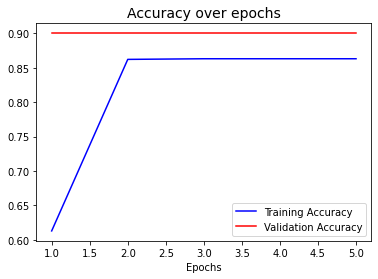

Best validation accuracy was 0.900 at epoch  0


In [87]:
# Obtain training and validation metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Accuracy over epochs
plt.plot(epochs, train_acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Print best validation accuracy and epoch
print("Best validation accuracy was %5.3f at epoch %2.f" % (np.max(val_acc), np.argmax(val_acc)))

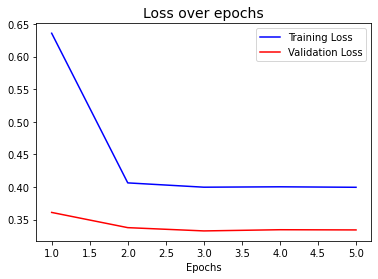

In [88]:
# Loss over epochs
plt.plot(epochs, train_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title("Loss over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [161]:
# Get accuracy on testing set
loss, accuracy = model.evaluate(test_x, test_y)
print('Accuracy on test dataset:', accuracy)

18/18 [==============================] - 1s 29ms/step - loss: 0.7479 - accuracy: 0.1229
Accuracy on test dataset: 0.12293577939271927


In [162]:
# Get predictions
test_pred = model.predict(test_x)

18/18 [==============================] - 1s 26ms/step


In [163]:
conf_matrix = tf.math.confusion_matrix(labels=test_y,
                                       predictions=np.rint(test_pred))
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[  0, 478],
       [  0,  67]], dtype=int32)>

In [113]:
test_pred

array([[0.30432066],
       [0.3045097 ],
       [0.30626485],
       [0.31478238],
       [0.30463877],
       [0.31792608],
       [0.30029643],
       [0.3397015 ],
       [0.30694547],
       [0.33531067],
       [0.3276646 ],
       [0.4077155 ],
       [0.33388355],
       [0.30374885],
       [0.34260914],
       [0.3009894 ],
       [0.33855614],
       [0.32395828],
       [0.3003736 ],
       [0.3034046 ],
       [0.31229863],
       [0.3013528 ],
       [0.33026937],
       [0.31278282],
       [0.3407457 ],
       [0.3051626 ],
       [0.32352683],
       [0.32598364],
       [0.3343657 ],
       [0.30902994],
       [0.30821592],
       [0.3106861 ],
       [0.32876238],
       [0.30999988],
       [0.318442  ],
       [0.32560006],
       [0.32248092],
       [0.3376668 ],
       [0.3000749 ],
       [0.32097998],
       [0.31432033],
       [0.30707264],
       [0.3380762 ],
       [0.33801436],
       [0.31961945],
       [0.32968724],
       [0.32216555],
       [0.366